In [13]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm # для выполнения не из jupyter: from tqdm import tqdm

# Параметры задачи

In [14]:
N_POINTS = 41
DOMAIN_SIZE = 1.0 # линейные размеры стороны расчётной области, единичная длина и ширина
N_ITERATIONS = 500 # число итераций решения
TIME_STEP_LENGTH = 0.001
KINEMATIC_VISCOSITY = 0.1 # кин. вязкость
DENSITY = 1.0 # 
HORIZONTAL_VELOCITY_TOP = 1.0 # скорость на верхней границе

N_PRESSURE_POISSON_ITERATIONS = 50
STABILITY_SAFETY_FACTOR = 0.5

# Расчётная сетка (массивы для хранения параметров потока)

## Геометрические сетки X и Y

Сетки хранят геометрические координаты границ ячеек

In [15]:
element_length = DOMAIN_SIZE / (N_POINTS - 1)
x = np.linspace(0.0, DOMAIN_SIZE, N_POINTS)
y = np.linspace(0.0, DOMAIN_SIZE, N_POINTS)

X, Y = np.meshgrid(x, y)

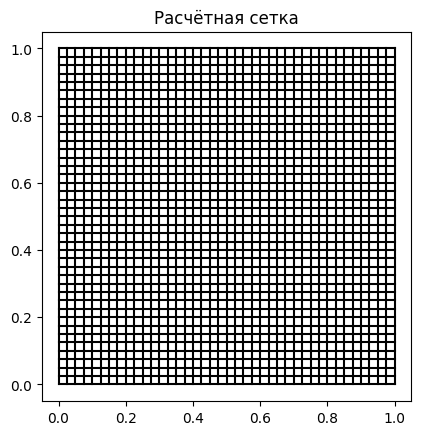

In [39]:
plt.plot(X, Y, "-k",) # use plot, not scatter
plt.gca().set_title("Расчётная сетка")
plt.gca().set_aspect('equal', 'box')
plt.plot(np.transpose(X), np.transpose(Y), "-k") # add this here
plt.show()

In [17]:
print("Сетка X:\n", X, "\n")
print("Сетка Y:\n", Y)

Сетка X:
 [[0.    0.025 0.05  ... 0.95  0.975 1.   ]
 [0.    0.025 0.05  ... 0.95  0.975 1.   ]
 [0.    0.025 0.05  ... 0.95  0.975 1.   ]
 ...
 [0.    0.025 0.05  ... 0.95  0.975 1.   ]
 [0.    0.025 0.05  ... 0.95  0.975 1.   ]
 [0.    0.025 0.05  ... 0.95  0.975 1.   ]] 

Сетка Y:
 [[0.    0.    0.    ... 0.    0.    0.   ]
 [0.025 0.025 0.025 ... 0.025 0.025 0.025]
 [0.05  0.05  0.05  ... 0.05  0.05  0.05 ]
 ...
 [0.95  0.95  0.95  ... 0.95  0.95  0.95 ]
 [0.975 0.975 0.975 ... 0.975 0.975 0.975]
 [1.    1.    1.    ... 1.    1.    1.   ]]


## Массивы для хранения ${v_x}$, ${v_x}$, ${p}$ и их инициализация 

Массивы объявляются по подобию прототипа - X, и сразу инициализируются (заполняются нулями)

In [18]:
vx_prev = np.zeros_like(X)
vy_prev = np.zeros_like(X)
p_prev = np.zeros_like(X)

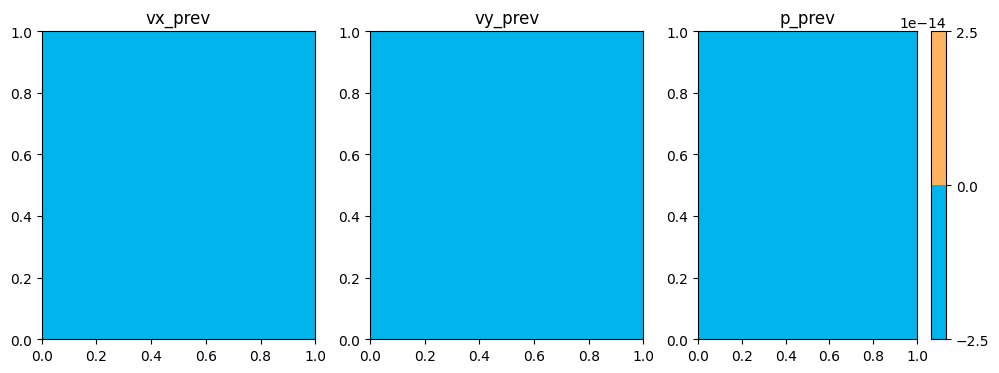

In [19]:
plt.figure(figsize=[12, 4])

plt.subplot(1,3,1, title="vx_prev")
plt.contourf(X[::2, ::2], Y[::2, ::2], vx_prev[::2, ::2], cmap="rainbow")

plt.subplot(1,3,2, title="vy_prev")
plt.contourf(X[::2, ::2], Y[::2, ::2], vy_prev[::2, ::2], cmap="rainbow")

plt.subplot(1,3,3, title="p_prev")
plt.contourf(X[::2, ::2], Y[::2, ::2], p_prev[::2, ::2], cmap="rainbow")

plt.colorbar()

# Операторы 

Функция для расчёта разности величины по x, в дискретном виде, для всей сетки, по формуле

${\dfrac{\partial{U}}{\partial{x}}=\dfrac{U_{x_{i-1},y_j}-U_{x_{i+1},y_j}}{2 \Delta{x}} }$

In [20]:
def ddx(f):
    diff = np.zeros_like(f)
    diff[1:-1, 1:-1] = ( f[1:-1, 2: ] - f[1:-1, 0:-2] ) / ( 2 * element_length )
    return diff

Функция для расчёта разности величины по y, в дискретном виде, для всей сетки, по формуле

${\dfrac{\partial{U}}{\partial{y}}=\dfrac{U_{x_i,y_{j+1}}-U_{x_i,y_{j-1}}}{2 \Delta{y}} }$

In [21]:
def ddy(f):
    diff = np.zeros_like(f)
    diff[1:-1, 1:-1] = ( f[2:  , 1:-1] - f[0:-2, 1:-1] ) / ( 2 * element_length )
    return diff

Функция для расчёта оператора Лапласа, в дискретном виде, для всей сетки, по формуле

${\Delta{U}=\dfrac{U_{x_{i},y_{j-1}}+U_{x_{i-1},y_j}-4U_{x_{i},y_j}+U_{x_{i},y_{j+1}}+U_{x_{i+1},y_{j}}} {\Delta{x}\Delta{y} } }$

In [22]:
def laplace(f):
    diff = np.zeros_like(f)
    diff[1:-1, 1:-1] = (
        f[1:-1, 0:-2] + f[0:-2, 1:-1] - 4 * f[1:-1, 1:-1] + f[1:-1, 2: ] + f[2: , 1:-1]
    ) / ( element_length**2 )
    return diff

# Вспомогательные операции

In [23]:
maximum_possible_time_step_length = ( 0.5 * element_length**2 / KINEMATIC_VISCOSITY)
if TIME_STEP_LENGTH > STABILITY_SAFETY_FACTOR * maximum_possible_time_step_length:
    raise RuntimeError("Stability is not guarenteed")

# Решение демонстрационное пошаговое

Система уравнений:

${\partial{\vec{v}}/\partial{t} + (\vec{v} \cdot \nabla) \vec{v} = \nu \nabla^2{\vec{v}}}$

${\nabla^2{p}= \rho/\Delta{t} \nabla \cdot \vec{v}}$

# Решение (до N итераций)

Система уравнений:

${\partial{\vec{v}}/\partial{t} + (\vec{v} \cdot \nabla) \vec{v} = \nu \nabla^2{\vec{v}}}$

${\nabla^2{p}= \rho/\Delta{t} \nabla \cdot \vec{v}}$

  0%|          | 0/500 [00:00<?, ?it/s]

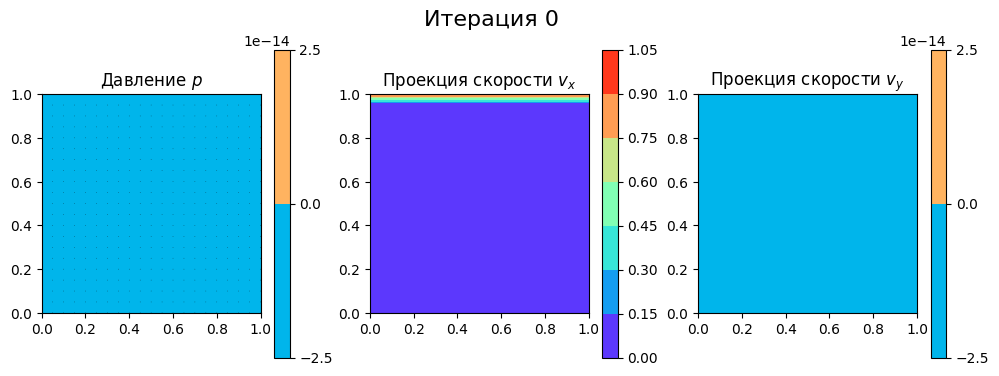

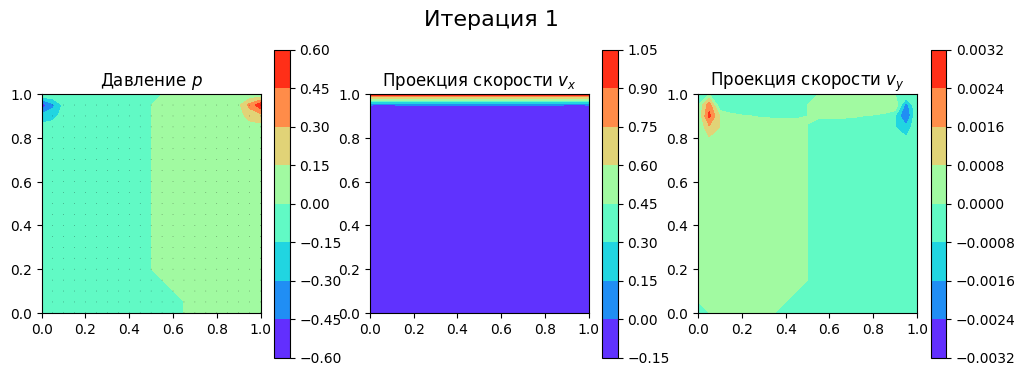

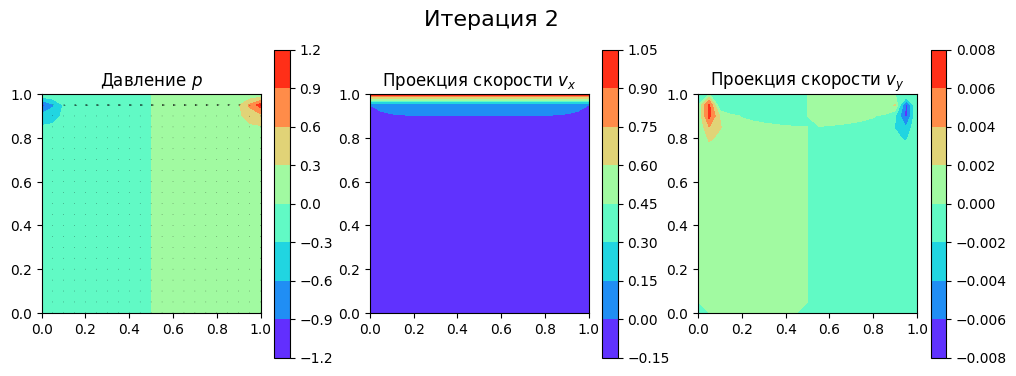

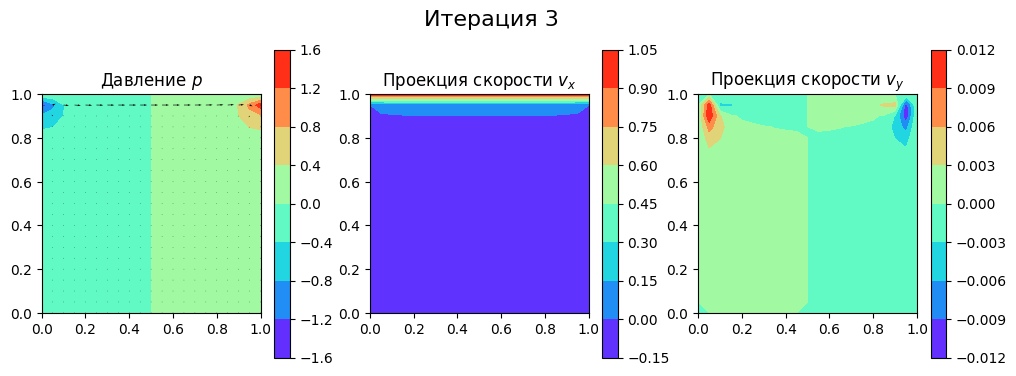

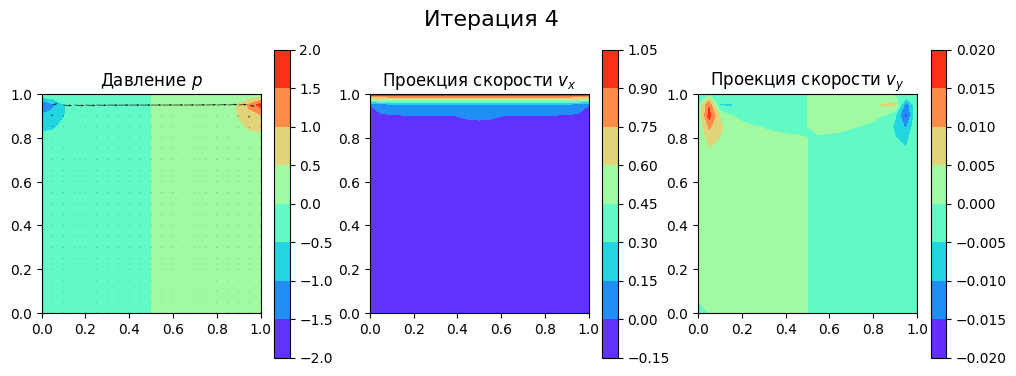

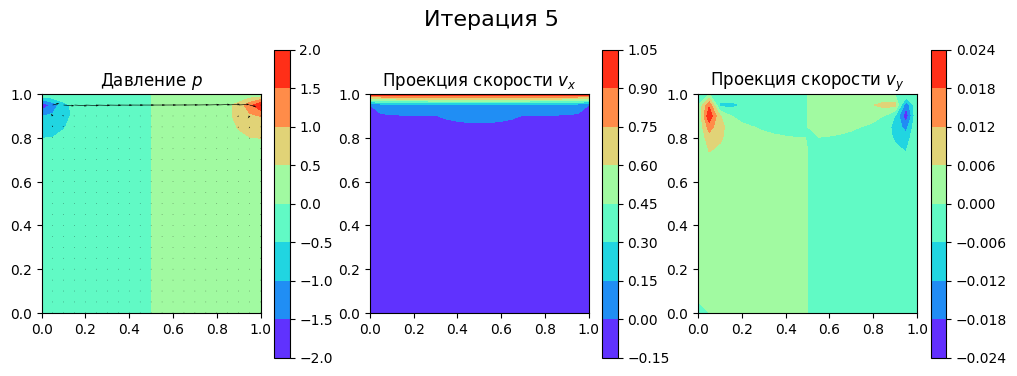

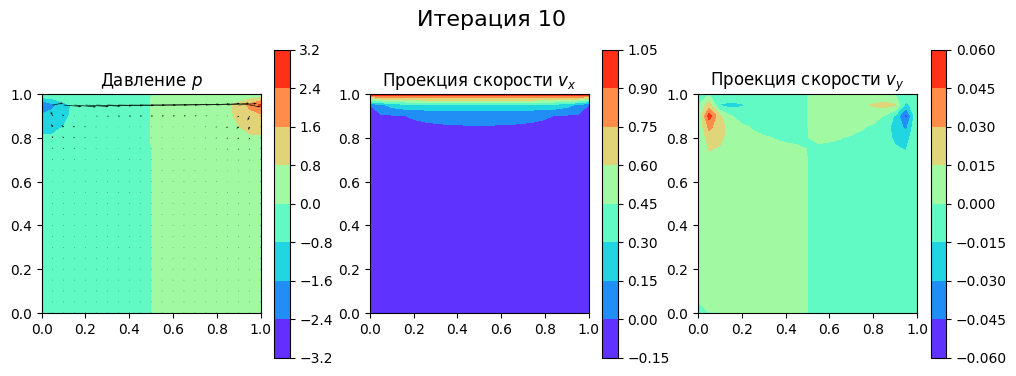

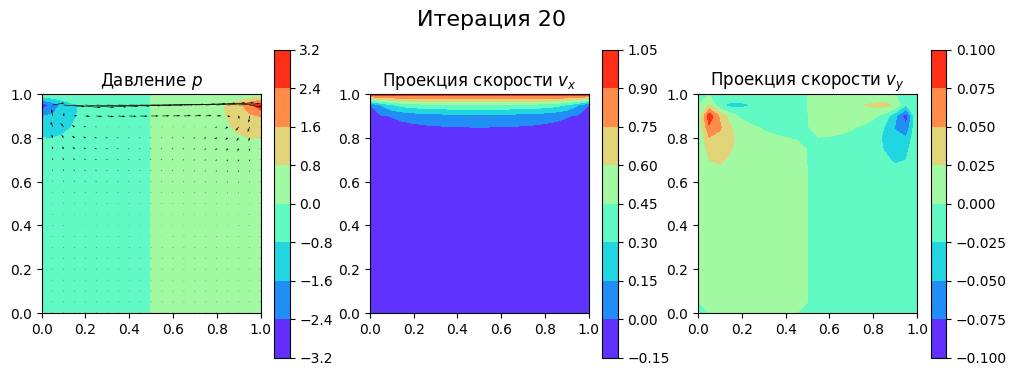

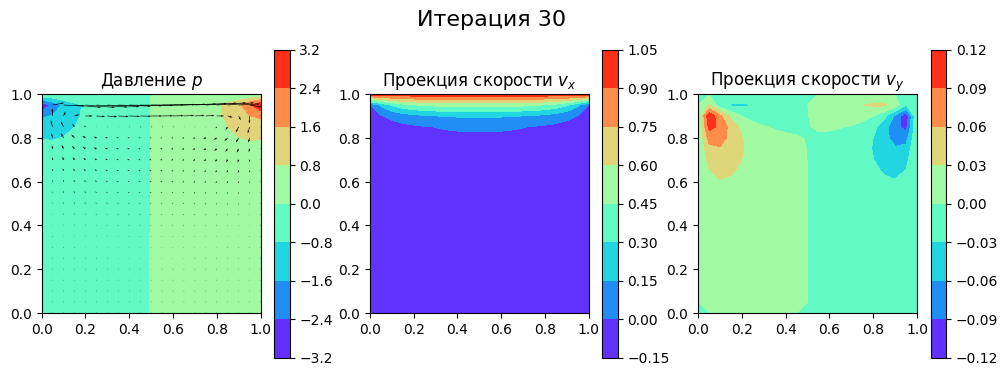

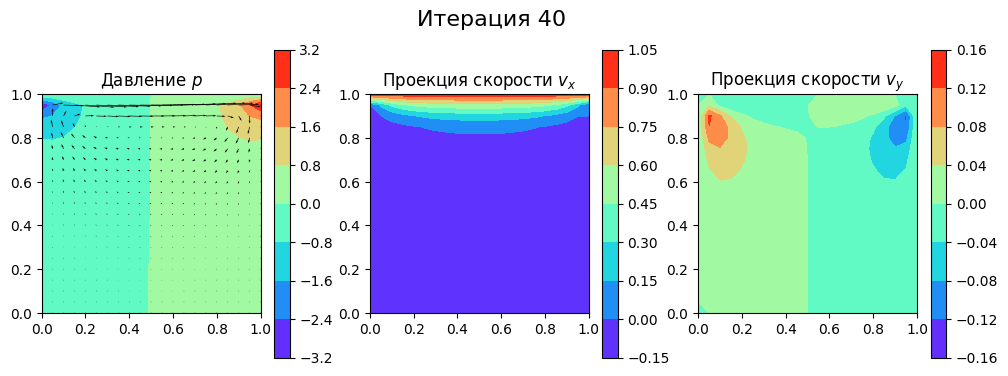

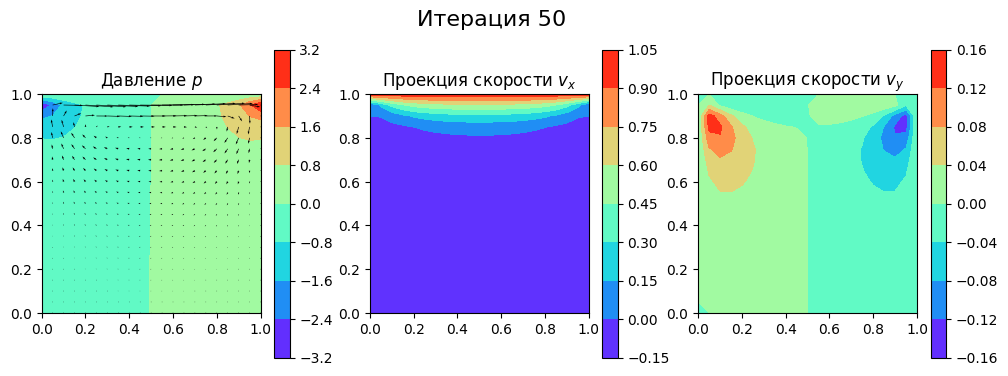

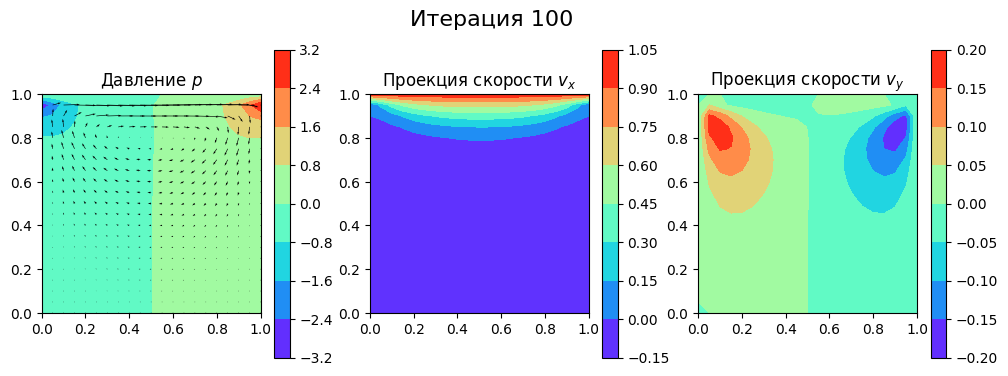

In [24]:
for iter in tqdm(range(N_ITERATIONS)):

    # предварительный шаг расчёта vx и vy из уравнений движения withovxt без учёта давления
    vx_tent = (
        vx_prev
        + TIME_STEP_LENGTH * (
            - (vx_prev * ddx(vx_prev) + vy_prev * ddy(vx_prev) )
            + KINEMATIC_VISCOSITY * laplace(vx_prev) )
        )
    vy_tent = (
        vy_prev
        + TIME_STEP_LENGTH * (
            - ( vx_prev * ddx(vy_prev) + vy_prev * ddy(vy_prev) )
            + KINEMATIC_VISCOSITY * laplace(vy_prev) )
        )

    # Задание граничных условий: гомогенные граничные условия по скорости типа Дирихле
    vx_tent[0, :] = 0.0 # vx, нижняя граница
    vx_tent[:, 0] = 0.0 # vx, левая граница
    vx_tent[:, -1] = 0.0 # vx, правая граница
    vx_tent[-1, :] = HORIZONTAL_VELOCITY_TOP # vx, верхняя граница
    vy_tent[0, :] = 0.0 # vy, нижняя граница
    vy_tent[:, 0] = 0.0 # vy, левая граница
    vy_tent[:, -1] = 0.0 # vy, правая граница
    vy_tent[-1, :] = 0.0 # vy, верхняя граница

    # Compute a pressure correction by solving the pressure-poisson equation
    rhs = ( DENSITY / TIME_STEP_LENGTH * ( ddx(vx_tent) + ddy(vy_tent) ) )

    # расчёт давления ∇²p = ρ/Δt ∇ ⋅ u   
    for _ in range(N_PRESSURE_POISSON_ITERATIONS):
        p_next = np.zeros_like(p_prev)
        p_next[1:-1, 1:-1] = 1/4 * (
            + p_prev[1:-1, 0:-2]
            + p_prev[0:-2, 1:-1]
            + p_prev[1:-1, 2:  ]
            + p_prev[2:  , 1:-1]
            - element_length**2
            * rhs[1:-1, 1:-1]
        )

        ### Гомогенные граничные условия по давлению 
        p_next[:, -1] = p_next[:, -2] # правая граница, типа Неймана
        p_next[0,  :] = p_next[1,  :] # нижняя граница, типа Неймана
        p_next[:,  0] = p_next[:,  1] # левая граница, типа Неймана
        p_next[-1, :] = 0.0 #  верхняя граница, типа Дирихле
        p_prev = p_next

    # Correct the velocities such that the flvxid stays incompressible
    vx_next = ( vx_tent - TIME_STEP_LENGTH / DENSITY * ddx(p_next) )
    vy_next = ( vy_tent - TIME_STEP_LENGTH / DENSITY * ddy(p_next) )

    ### Гомогенные граничные условия по скорости типа Дирихле
    vx_next[0, :] = 0.0
    vx_next[:, 0] = 0.0
    vx_next[:, -1] = 0.0
    vx_next[-1, :] = HORIZONTAL_VELOCITY_TOP
    vy_next[0, :] = 0.0
    vy_next[:, 0] = 0.0
    vy_next[:, -1] = 0.0
    vy_next[-1, :] = 0.0

    # Advance in time
    vx_prev = vx_next
    vy_prev = vy_next
    p_prev = p_next

    

    if(iter in [0, 1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 100]):
        fig = plt.figure(figsize=[12, 4])
        fig.suptitle(f"Итерация {iter}", fontsize=16)
        # print(iter)
        plt.subplot(1,3,1, title="Давление ${p}$")
        plt.gca().set_aspect('equal', 'box')
        plt.contourf(X[::2, ::2], Y[::2, ::2], p_next[::2, ::2], cmap="rainbow")
        plt.colorbar()
        plt.quiver(X[::2, ::2], Y[::2, ::2],
                   vx_next[::2, ::2], vy_next[::2, ::2], color="black")
        
        plt.subplot(1,3,2, title="Проекция скорости ${v_x}$")
        plt.gca().set_aspect('equal', 'box')
        plt.contourf(X[::2, ::2], Y[::2, ::2], vx_next[::2, ::2], cmap="rainbow")
        plt.colorbar()
        
        
        plt.subplot(1,3,3, title="Проекция скорости ${v_y}$")
        plt.gca().set_aspect('equal', 'box')
        plt.contourf(X[::2, ::2], Y[::2, ::2], vy_next[::2, ::2], cmap="rainbow")
        plt.colorbar()
        plt.show()

# Простая визуализация результатов

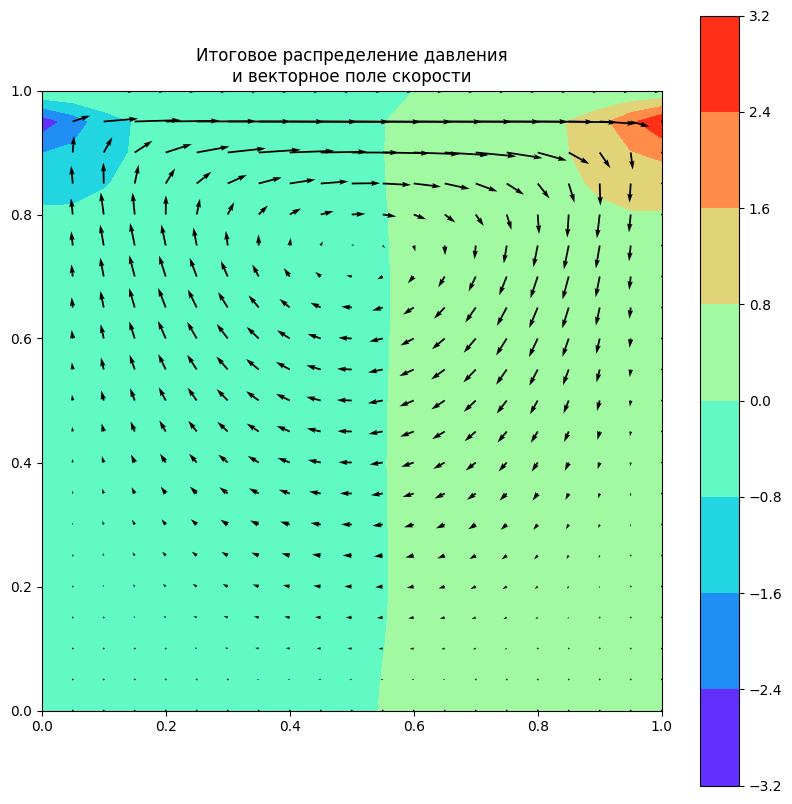

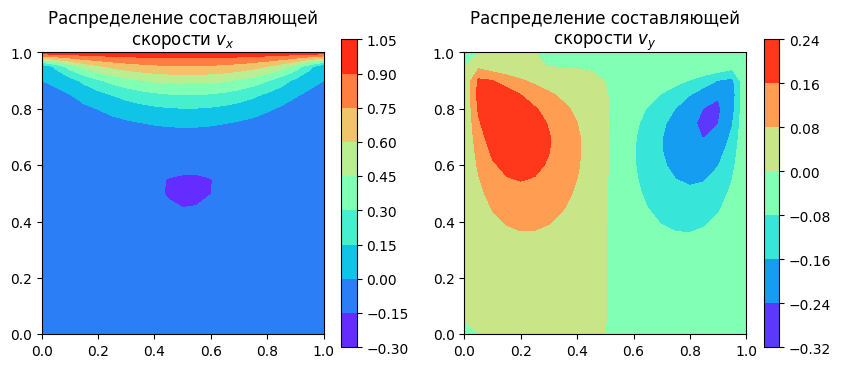

In [25]:
# plt.style.use("dark_background")
plt.figure(figsize=[10, 10])
plt.gca().set_aspect('equal', 'box')
plt.gca().set_title("Итоговое распределение давления\nи векторное поле скорости")
# plt.set_title("Давление и вектора скорости")

# plt.subplot(3,2,1)
# контурный график давления
plt.contourf(X[::2, ::2], Y[::2, ::2], p_next[::2, ::2], cmap="rainbow")
plt.colorbar()

# линии тока
# plt.streamplot(X[::2, ::2], Y[::2, ::2],
#                vx_next[::2, ::2], vy_next[::2, ::2], color="black")

# векторное поле
plt.quiver(X[::2, ::2], Y[::2, ::2],
           vx_next[::2, ::2], vy_next[::2, ::2], color="black")

plt.figure(figsize=[10, 4])
# график v_x
plt.subplot(1,2,1, title="Распределение составляющей\nскорости ${v_x}$")
plt.gca().set_aspect('equal', 'box')
plt.contourf(X[::2, ::2], Y[::2, ::2], vx_next[::2, ::2], cmap="rainbow")
plt.colorbar()

# график v_y
plt.subplot(1,2,2, title="Распределение составляющей\nскорости ${v_y}$")
plt.gca().set_aspect('equal', 'box')
plt.contourf(X[::2, ::2], Y[::2, ::2], vy_next[::2, ::2], cmap="rainbow")
plt.colorbar()

# plt.xlim((0, 1))
# plt.ylim((0, 1))
# plt.show()

# Визуализация параметров жидкости/газа в VTK (ЛР 2.2)

In [40]:
# !pip install pyvista[all]
import pyvista as pv
from pyvista import examples

## Создать 3D-домен и решение, путём повторения 2D по оси Z

In [41]:
X3d = np.tile(X, (N_POINTS,1,1))
print("X3d.shape = ", X3d.shape)

Y3d = np.tile(Y, (N_POINTS,1,1))
print("Y3d.shape = ", Y3d.shape)

Vx3d = np.tile(vx_next, (N_POINTS,1,1))
print("Vx3d.shape = ", Vx3d.shape)

Vy3d = np.tile(vy_next, (N_POINTS,1,1))
print("Vy3d.shape = ", Vy3d.shape)

P3d = np.tile(p_next, (N_POINTS,1,1))
print("P3d.shape = ", P3d.shape)

X3d.shape =  (41, 41, 41)
Y3d.shape =  (41, 41, 41)
Vx3d.shape =  (41, 41, 41)
Vy3d.shape =  (41, 41, 41)
P3d.shape =  (41, 41, 41)


## Создание объектов PyVista

In [85]:
# на основе https://docs.pyvista.org/version/stable/examples/01-filter/streamlines.html#custom-3d-vector-field

pv.global_theme.cmap = 'jet'
mesh = pv.ImageData(
    dimensions=np.array(X3d.shape),
    spacing=(element_length, element_length, element_length),
    origin=(-0.5, -0.5, -0.5))

# x_pyvista = mesh.points[:, 0]
# y_pyvista = mesh.points[:, 1]
# z_pyvista = mesh.points[:, 2]

vectors = np.empty((mesh.n_points, 3))
# vectors[:, 0].shape

vectors[:, 0] = Vx3d.flatten()
vectors[:, 1] = Vy3d.flatten()
vectors[:, 2] = np.zeros_like(vectors[:, 0])

pressure = np.empty((mesh.n_points, 1))
pressure[:,0] = P3d.flatten()

mesh['velocity'] = vectors
mesh['pressure'] = pressure

stream, src = mesh.streamlines(
    'velocity',
    return_source=True,
    terminal_speed=0.0,
    n_points=100,
    source_radius=0.5,
    # ,
)


# stream.tube(radius=0.0015).plot()
plotter = pv.Plotter()

plotter.add_mesh(
    stream.tube(radius=0.0015),
    scalar_bar_args={'title': 'Скорость'},
    show_scalar_bar=False
)

plotter.add_scalar_bar(
    'velocity',
    # interactive=True,
    vertical=True,
    # position_x=0.0,
    # position_y=0.0,
    # title_font_size=35,
    # label_font_size=30,
    # outline=True,
    # fmt='%10.5f',
)

plotter.add_volume(
    mesh,
    scalars='pressure',
    opacity='linear',
    scalar_bar_args={'title': 'Давление'},
    show_scalar_bar=False,
)

# plotter.add_scalar_bar(
#     'pressure',
#     # interactive=True,
#     vertical=True,
#     position_x=0.5,
#     position_y=0.5,
#     # title_font_size=35,
#     # label_font_size=30,
#     # outline=True,
#     # fmt='%10.5f',
# )

plotter.set_background('white', top='white')
plotter.show()
# pl.show()

Widget(value='<iframe src="http://localhost:52133/index.html?ui=P_0x1daf8da28f0_39&reconnect=auto" class="pyvi…